In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import csv
import argparse
import os

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

f:\pyCharm\pythonProjects\labs_7_kurs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Сгенерируем временной ряд с помощью прилагаемого файла

In [4]:
def generate_time_series(n_points=1000, has_trend=True, has_seasonality=True, seed=None):
    """
    Генерирует временной ряд со случайными параметрами без использования
    Pandas
    Параметры:
    ----------
    n_points : int
    Количество точек данных
    has_trend : bool
    Добавлять ли тренд
    has_seasonality : bool
    Добавлять ли сезонность
    seed : int или None
    Seed для воспроизводимости
    Возвращает:
    -----------
    tuple: (dates, values) где dates - список строк дат, values - список
    значений
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    # Генерируем временные метки (ежедневные данные начиная с 2020-01-01)
    start_date = datetime(2020, 1, 1)
    dates = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(n_points)]
    
    # Базовый шум (случайная компонента)
    noise = np.random.normal(0, 5, n_points)
    
    # Инициализируем компоненты
    trend_component = np.zeros(n_points)
    seasonal_component = np.zeros(n_points)
    
    # Генерируем тренд, если требуется
    if has_trend:
        # Случайно выбираем тип тренда: линейный, квадратичный или логарифмический
        trend_type = np.random.choice(['linear', 'quadratic', 'logarithmic'])
    
    if trend_type == 'linear':
        # Линейный тренд: y = mx + b
        slope = np.random.uniform(-0.5, 0.5) # случайный наклон
        intercept = np.random.uniform(50, 100) # случайное начальное значение
        trend_component = slope * np.arange(n_points) + intercept
    elif trend_type == 'quadratic':
        # Квадратичный тренд: y = ax^2 + bx + c
        a = np.random.uniform(-0.001, 0.001)
        b = np.random.uniform(-0.1, 0.1)
        c = np.random.uniform(50, 100)
        x = np.arange(n_points)
        trend_component = a * x**2 + b * x + c
    else: # logarithmic
        # Логарифмический тренд: y = a*log(x+1) + b
        a = np.random.uniform(10, 30)
        b = np.random.uniform(50, 100)
        trend_component = a * np.log(np.arange(n_points) + 1) + b
    
    # Генерируем сезонность, если требуется
    if has_seasonality:
        # Случайное количество сезонных компонент (1-3)
        n_seasons = np.random.randint(1, 4)
        for _ in range(n_seasons):
            # Случайные параметры для каждой сезонной компоненты
            amplitude = np.random.uniform(10, 30) # амплитуда
            period = np.random.uniform(30, 365) # период в днях
            phase = np.random.uniform(0, 2*np.pi) # фаза
            # Создаем сезонную компоненту (синусоида)
            seasonal_component += amplitude * np.sin(2*np.pi*np.arange(n_points)/period + phase)
    # Комбинируем все компоненты
    values = noise + trend_component + seasonal_component
    return dates, values

In [5]:
def plot_time_series(dates, values, figsize=(14, 6)):
    """
    Визуализирует временной ряд без использования Pandas
    Параметры:
    ----------
    dates : list
    Список дат в строковом формате
    values : list или np.array
    Список значений временного ряда
    figsize : tuple
    Размер фигуры
    """
    # Преобразуем строки дат в объекты datetime для matplotlib
    date_objects = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates]
    
    plt.figure(figsize=figsize)
    
    # Строим график временного ряда
    plt.plot(date_objects, values, label='Временной ряд', color='blue', linewidth=1.5)
    plt.title('Сгенерированный временной ряд', fontsize=16, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Значение', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Автоматически форматируем ось X для дат
    plt.gcf().autofmt_xdate()
    
    # Добавляем информацию о данных
    values_array = np.array(values)
    stats_text = f"Всего точек: {len(values)}\nСреднее:{np.mean(values_array):.2f}\nСтандартное отклонение:{np.std(values_array):.2f}"
    plt.figtext(0.02, 0.02, stats_text, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    plt.tight_layout()
    plt.show()

In [23]:
dates, values = generate_time_series() #параметры по умолчанию
df = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'value': values
})
df = df.set_index('date')
df.to_csv('generated_time_series.csv')

график сгенерированного временного ряда

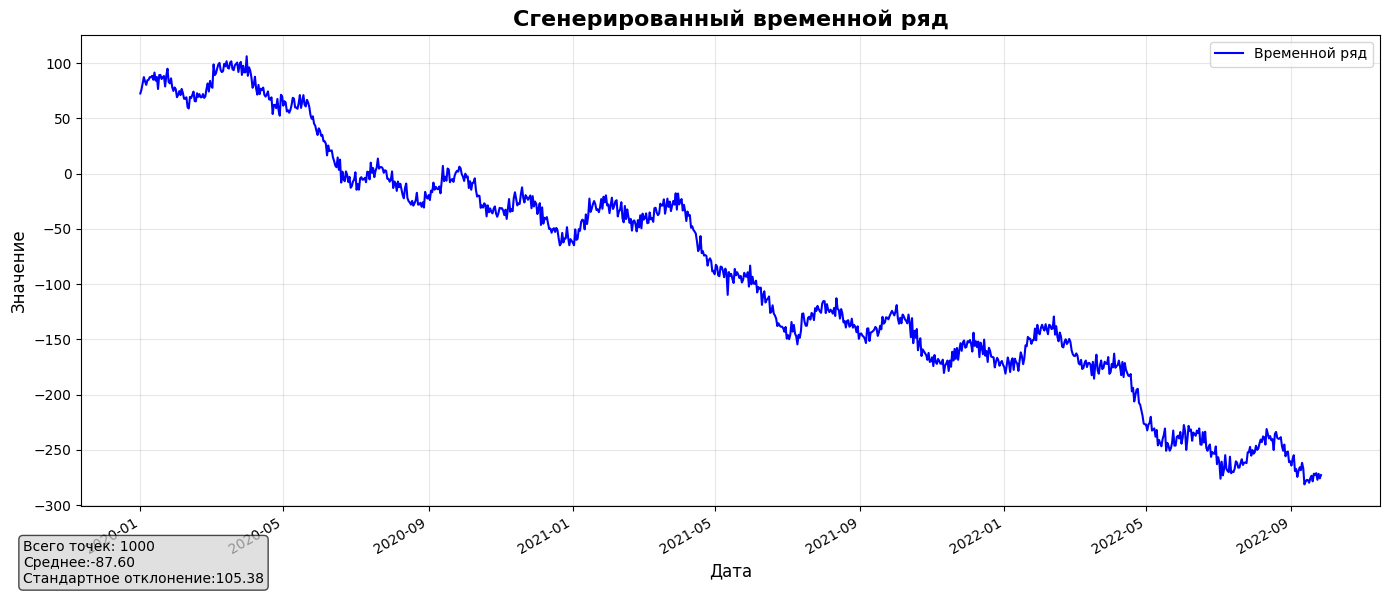

In [24]:
plot_time_series(dates, values)

статистические тесты

In [25]:
result_adf = adfuller(df['value'])
print(f'ADF Statistic: {result_adf[0]}, p-value: {result_adf[1]}')
print("Critical Values:")
for key, value in result_adf[4].items():
    print(f" {key}: {value}")

ADF Statistic: -0.5793050878715577, p-value: 0.8755899982231781
Critical Values:
 1%: -3.43706091543889
 5%: -2.8645028204932483
 10%: -2.568347558984588


In [26]:
result_kpss = kpss(df['value'])
print(f'KPSS Statistic: {result_kpss[0]}, p-value: {result_kpss[1]}')
print("Critical Values:")
for key, value in result_kpss[3].items():
    print(f" {key}: {value}")

KPSS Statistic: 4.887440652178156, p-value: 0.01
Critical Values:
 10%: 0.347
 5%: 0.463
 2.5%: 0.574
 1%: 0.739


C:\Users\1\AppData\Local\Temp\ipykernel_18440\1695851709.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(df['value'])


Проведем разделение ряда на компоненты

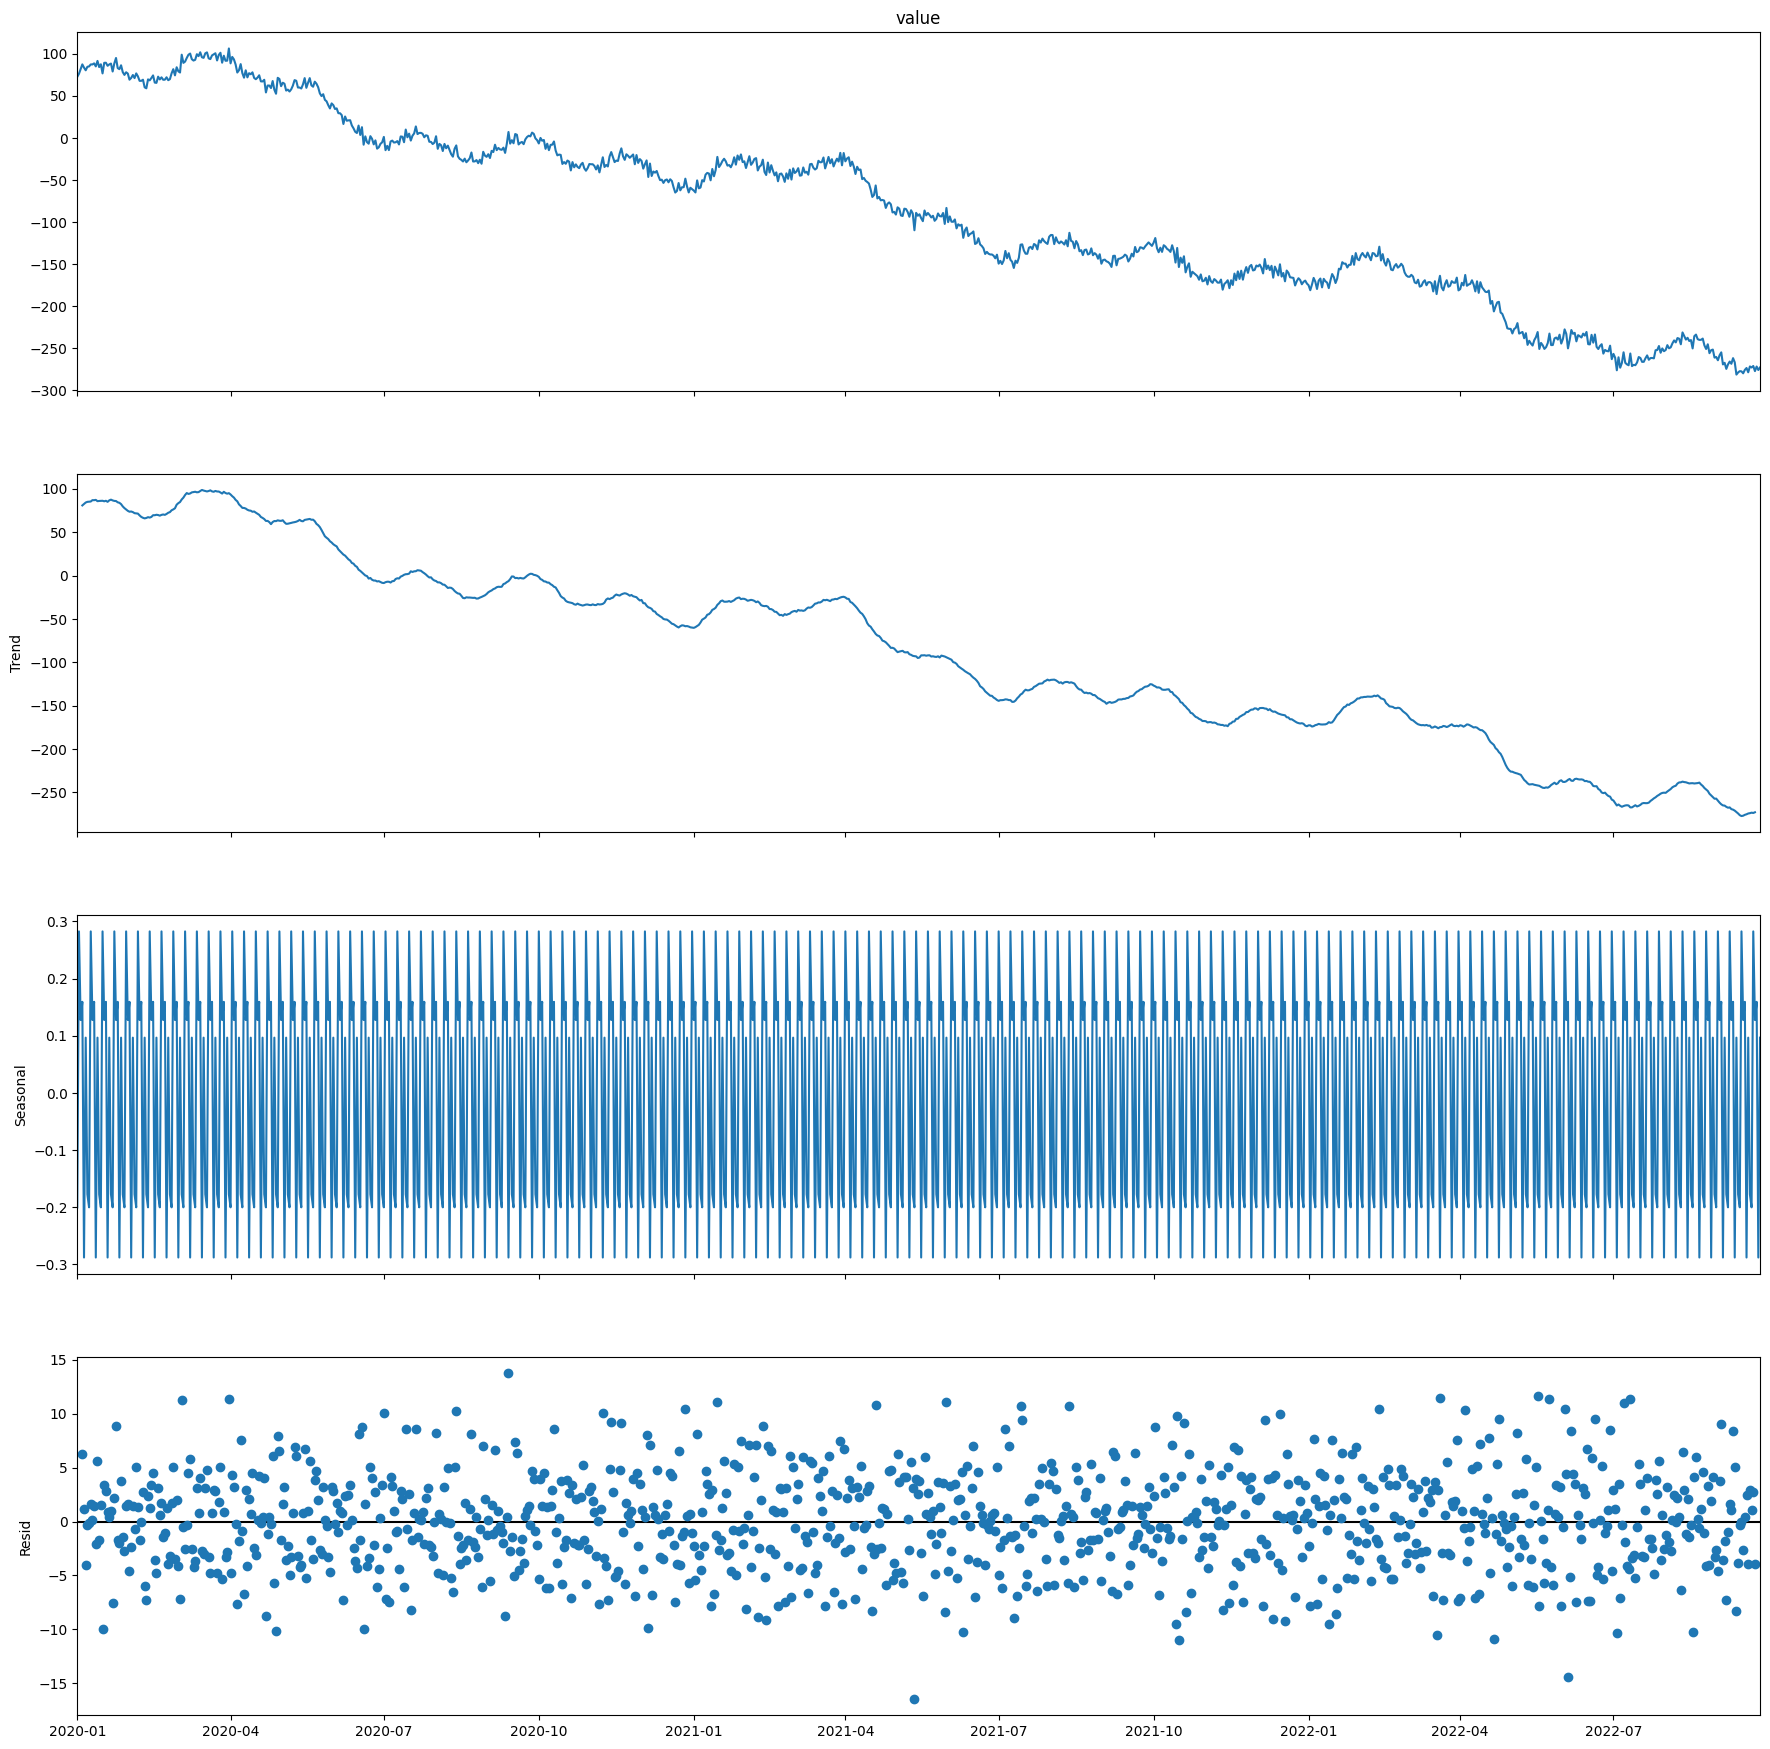

In [27]:
decomposiotion = seasonal_decompose(df['value'], model='additive')
decomposiotion.plot().set_size_inches(20, 20)
plt.show()

Отрисуем автокорреляционные функции

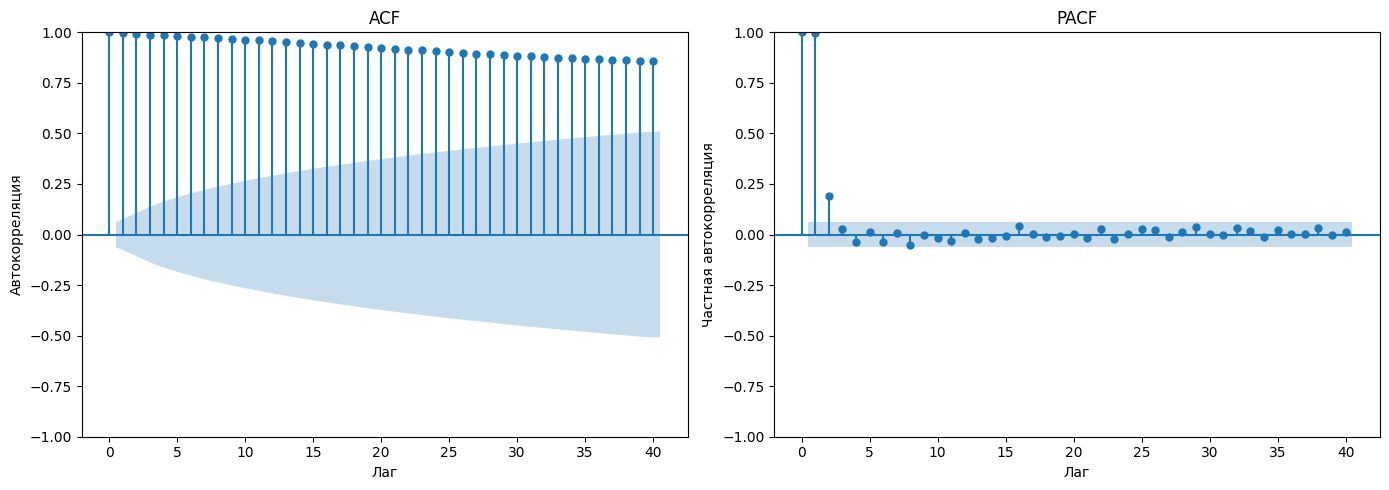

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF исходного ряда
plot_acf(df['value'].dropna(), lags=40, ax=axes[0], title='ACF')
axes[0].set_xlabel('Лаг')
axes[0].set_ylabel('Автокорреляция')

plot_pacf(df['value'].dropna(), lags=40, ax=axes[1], title='PACF')
axes[1].set_xlabel('Лаг')
axes[1].set_ylabel('Частная автокорреляция')
result = seasonal_decompose(df['value'], model='additive', period=12)
residuals = result.resid.dropna()

plt.tight_layout()
plt.show()

обучающие и тестовые данные

In [29]:
train_size = int(len(df) * 0.9)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

в сгенерированном временном ряде присутсвует явная сезонность и тренд. Трендовая компонента имеет устойчивую динамику с локальными колебаниями, что означает, что ряд не является стационарным, а занчит нужно применить дифференцирование.
Исходя из этого, подойдет модель SARIMAX. Она учитывает как тренд, так и сезонность и подходит для нестационарных временных рядов.

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(train_df['value'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

f:\pyCharm\pythonProjects\labs_7_kurs\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
f:\pyCharm\pythonProjects\labs_7_kurs\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
f:\pyCharm\pythonProjects\labs_7_kurs\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      value   No. Observations:                  900
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -2851.926
Date:                                    Sun, 14 Dec 2025   AIC                           5725.851
Time:                                            13:37:44   BIC                           5778.666
Sample:                                        01-01-2020   HQIC                          5746.028
                                             - 06-18-2022                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2132      0.077     -2.763      0.006      -0.365      -0.062
ar.L2         -0.0998      0.056     -1.770      0.077      -0.210       0.011
ma.L1         -0.5055      0.075     -6.769      0.000      -0.652      -0.359
ar.S.L12      -0.1102      0.156     -0.707      0.480      -0.416       0.195
ar.S.L24      -0.2410      0.124     -1.937      0.053      -0.485       0.003
ar.S.L36      -0.9440      0.161     -5.847      0.000      -1.260      -0.628
ar.S.L48       0.1458      0.040      3.615      0.000       0.067       0.225
ma.S.L12       0.2354      0.178      1.325      0.185      -0.113       0.584
ma.S.L24       0.2594      0.202      1.285      0.199      -0.136       0.655
ma.S.L36       0.9802      0.310      3.164      0.002       0.373       1.587
sigma2        30.9226      7.825      3.952      0.000      15.585      46.260
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.55   Prob(JB):                         0.54
Heteroskedasticity (H):               1.16   Skew:                             0.06
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

метрики по тестовым данным

In [31]:
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R²': r2
    }
    return metrics

In [32]:
arima_pred = arima_result.predict(start = len(train_df), end = len(df)-1, typ="levels")
calculate_metrics(test_df['value'], arima_pred, 'ARIMA')

f:\pyCharm\pythonProjects\labs_7_kurs\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


{'MAE': 7.446701690549117,
 'MSE': 88.82804284406282,
 'RMSE': np.float64(9.424863014604659),
 'MAPE (%)': 2.816181434577584,
 'R²': 0.4703683632072515}

MAE - модель в среднем ошибается примерно на 7–8 единиц измеряемой величины.
MSE и RMSE - Значение RMSE чуть выше MAE говорит о наличии отдельных участков, где ошибка прогноза возрастает (что типично для данных с трендом и шумом).
MAPE - Средняя ошибка прогноза составляет менее 3 %, что является хорошим результатом и говорит о высокой точности модели в относительном выражении.
R² - модель объясняет около 47 % вариации тестовых данных. Такое значение является довольно ожидаемым из за наличия шума и сложного тренда

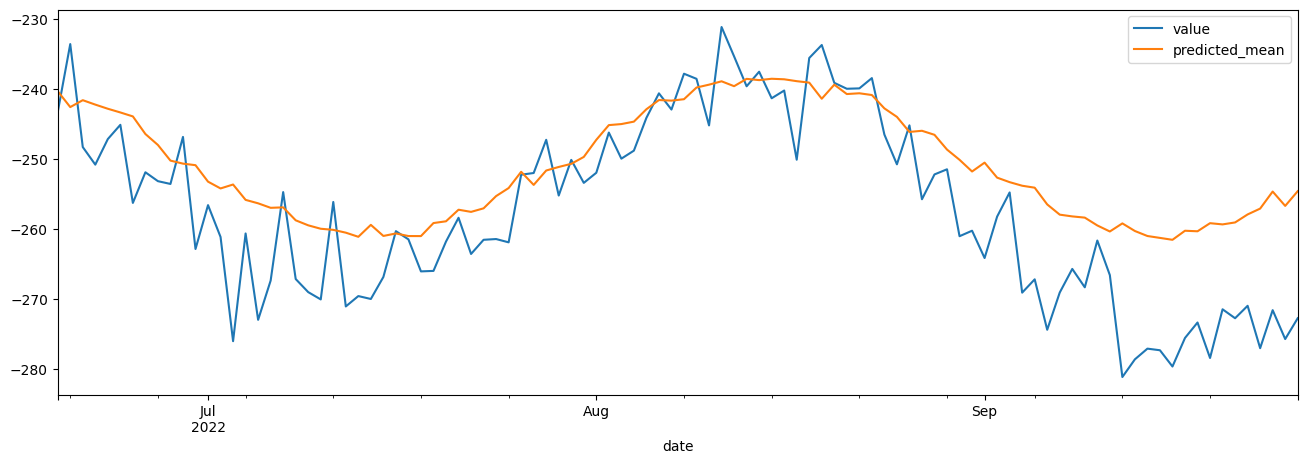

In [33]:
test_df['value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

Сгенерируем предсказание временного ряда

In [34]:
forecast_steps = 100
forecast_obj = arima_result.get_forecast(steps=forecast_steps)
forecast_values = forecast_obj.predicted_mean
confidence_intervals = forecast_obj.conf_int()
forecast_df = pd.DataFrame({
    'forecast': forecast_values,
    'lower_ci': confidence_intervals.iloc[:, 0],
    'upper_ci': confidence_intervals.iloc[:, 1]
})

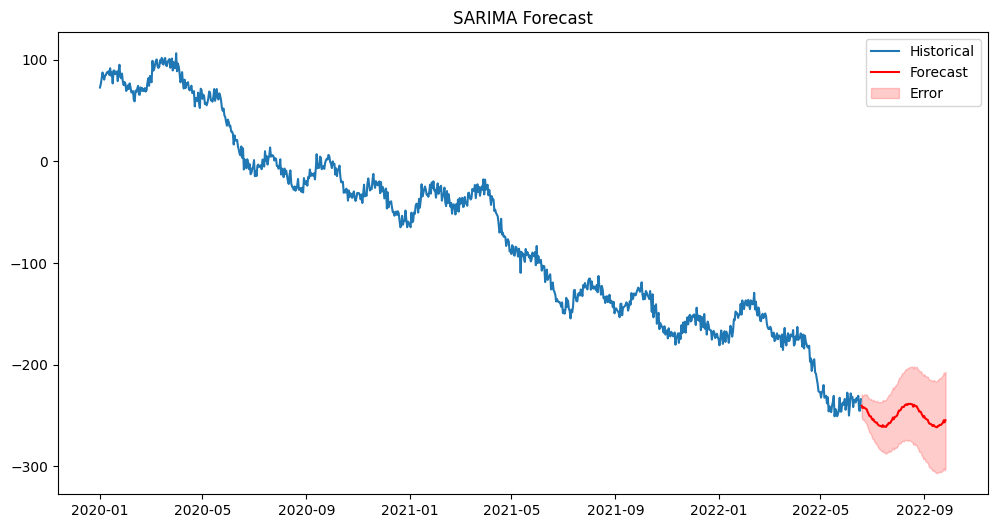

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['value'], label='Historical')
forecast_index = pd.date_range(
    start=train_df.index[-1], 
    periods=forecast_steps + 1, 
    freq='D'
)[1:]
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(
    forecast_index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='red', alpha=0.2, label='Error'
)
plt.legend()
plt.title('SARIMA Forecast')
plt.show()